## Import libraries

In [502]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    ConstantKernel as C,
    ExpSineSquared,
    DotProduct,
    WhiteKernel
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import root_mean_squared_error, r2_score

## Read in data

In [503]:
# Read data
train = pd.read_csv('./processed_data/train.csv')
train['tpep_pickup_datetime'] = pd.to_datetime(train['tpep_pickup_datetime'])

# Grab hour interval
train['hour'] = train['tpep_pickup_datetime'].dt.hour
train = train.set_index('tpep_pickup_datetime')

# Add simple index after setting time index
train['time_index'] = range(1, len(train) + 1)

train.head()

,passenger_count,trip_distance,DOLocationID,fare_amount,total_amount,tip_amount,pickup_count,is_holiday,pickup_time,weekday,hour,time_index
tpep_pickup_datetime,,,,,,,,,,,,
2022-01-24 00:00:00,1395.0,2119.58,181615,10845.93,16718.85,1.96,1134,0,2022-01-24 00:00:00,0,0,1
2022-01-24 12:00:00,2234.0,4223.13,269775,18541.88,28725.63,2.16,1676,0,2022-01-24 12:00:00,0,12,2
2022-01-25 00:00:00,1541.0,2519.35,203483,12578.37,19205.72,2.00,1234,0,2022-01-25 00:00:00,1,0,3
2022-01-25 12:00:00,1845.0,3335.29,224687,15507.65,24210.65,2.16,1419,0,2022-01-25 12:00:00,1,12,4
2022-01-26 00:00:00,1536.0,2246.81,204445,11883.31,18429.15,2.00,1222,0,2022-01-26 00:00:00,2,0,5


In [504]:
# Read data
test = pd.read_csv('./processed_data/test.csv')
test['tpep_pickup_datetime'] = pd.to_datetime(test['tpep_pickup_datetime'])

# Grab hour interval
test['hour'] = test['tpep_pickup_datetime'].dt.hour
test = test.set_index('tpep_pickup_datetime')

# Add simple index after setting time index
test['time_index'] = range(1, len(test) + 1)
test.head()

,passenger_count,trip_distance,DOLocationID,fare_amount,total_amount,tip_amount,pickup_count,is_holiday,pickup_time,weekday,hour,time_index
tpep_pickup_datetime,,,,,,,,,,,,
2024-01-22 00:00:00,1418.0,2174.20,198232,16627.86,24696.92,2.635,1184,0,2024-01-22 00:00:00,0,0,1
2024-01-22 12:00:00,2189.0,4011.96,292901,26816.92,41948.14,3.080,1790,0,2024-01-22 12:00:00,0,12,2
2024-01-23 00:00:00,2081.0,3412.25,287836,26783.81,39641.47,3.000,1736,0,2024-01-23 00:00:00,1,0,3
2024-01-23 12:00:00,2562.0,4830.78,333568,34576.37,52628.30,3.400,2048,0,2024-01-23 12:00:00,1,12,4
2024-01-24 00:00:00,1974.0,3455.66,286438,24981.77,37464.84,2.800,1710,0,2024-01-24 00:00:00,2,0,5


In [505]:
# See data charactertistcs
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 452 entries, 2022-01-24 00:00:00 to 2023-05-15 12:00:00
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   passenger_count  452 non-null    float64
 1   trip_distance    452 non-null    float64
 2   DOLocationID     452 non-null    int64  
 3   fare_amount      452 non-null    float64
 4   total_amount     452 non-null    float64
 5   tip_amount       452 non-null    float64
 6   pickup_count     452 non-null    int64  
 7   is_holiday       452 non-null    int64  
 8   pickup_time      452 non-null    object 
 9   weekday          452 non-null    int64  
 10  hour             452 non-null    int32  
 11  time_index       452 non-null    int64  
dtypes: float64(5), int32(1), int64(5), object(1)
memory usage: 44.1+ KB


In [506]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 226 entries, 2024-01-22 00:00:00 to 2024-05-13 12:00:00
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   passenger_count  226 non-null    float64
 1   trip_distance    226 non-null    float64
 2   DOLocationID     226 non-null    int64  
 3   fare_amount      226 non-null    float64
 4   total_amount     226 non-null    float64
 5   tip_amount       226 non-null    float64
 6   pickup_count     226 non-null    int64  
 7   is_holiday       226 non-null    int64  
 8   pickup_time      226 non-null    object 
 9   weekday          226 non-null    int64  
 10  hour             226 non-null    int32  
 11  time_index       226 non-null    int64  
dtypes: float64(5), int32(1), int64(5), object(1)
memory usage: 22.1+ KB


In [507]:
## SHRINK SIZES IF NECESSARY
#train = train[:1000]
#test = test[:1000]

## EDA

<Axes: >

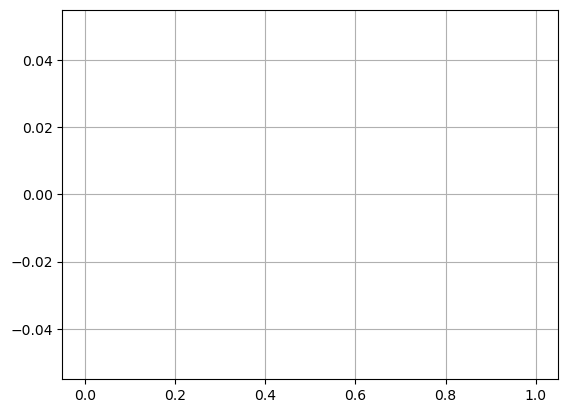

In [508]:
under_50 = train[train['pickup_count'] < 50]['hour']
under_50.hist() # When under 50 happens, per hour

In [509]:
train.groupby('hour')['pickup_count'].mean()

hour
0     1350.548673
12    2276.699115
Name: pickup_count, dtype: float64

<Axes: >

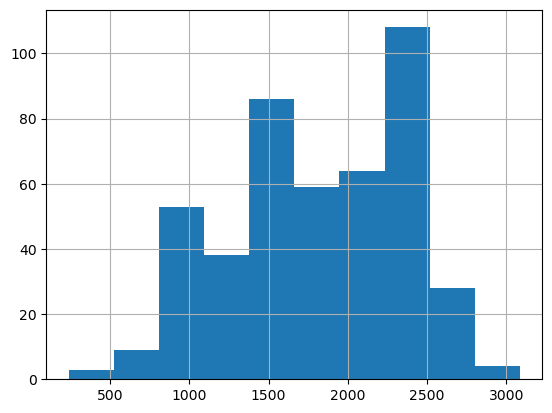

In [510]:
train['pickup_count'].hist()

<Axes: >

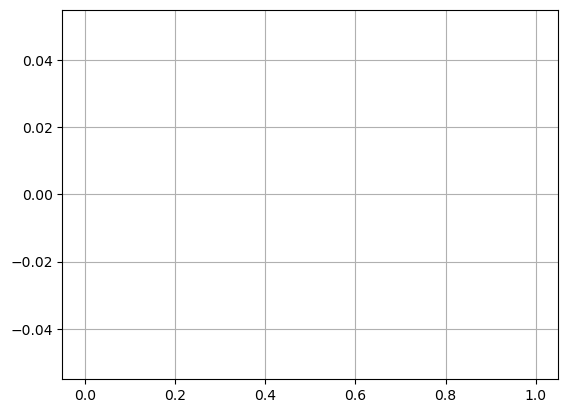

In [511]:
under_50_test = test[test['pickup_count'] < 50]['hour']
under_50_test.hist()

In [512]:
test.groupby('hour')['pickup_count'].mean()

hour
0     1298.530973
12    2333.327434
Name: pickup_count, dtype: float64

<Axes: >

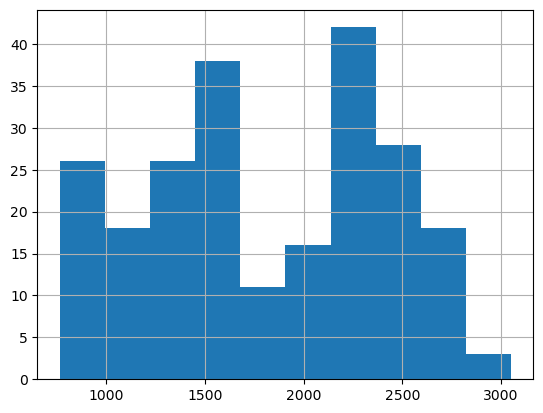

In [513]:
test['pickup_count'].hist()

## Plot general Time Series

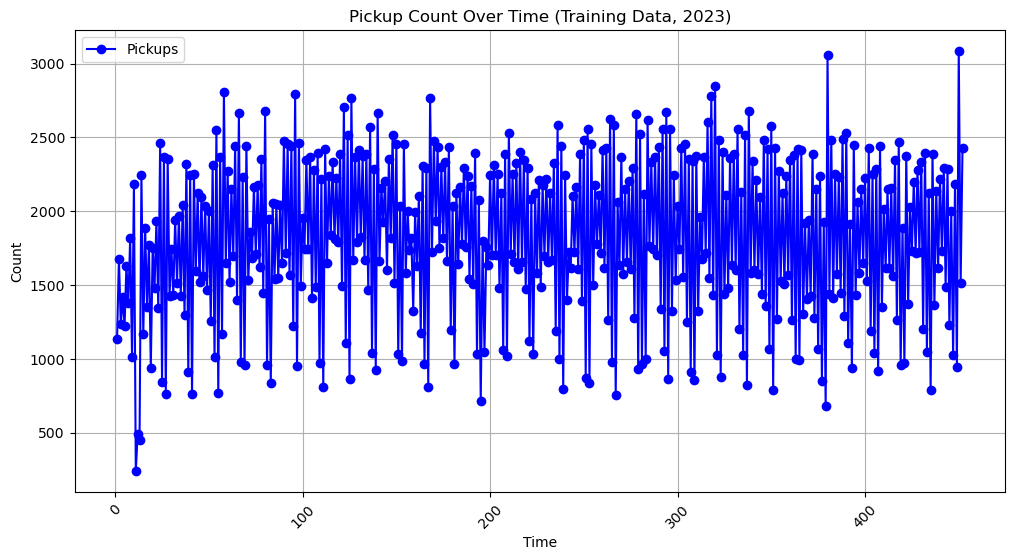

In [514]:
plt.figure(figsize=(12, 6))
plt.plot(train['time_index'], train['pickup_count'], marker='o', label='Pickups', color='blue')
plt.title('Pickup Count Over Time (Training Data, 2023)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

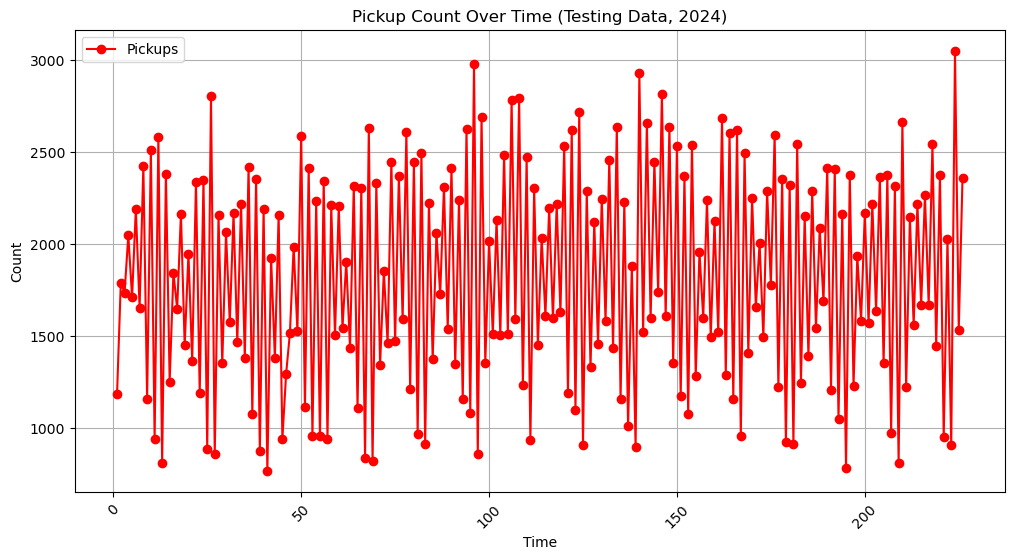

In [515]:
plt.figure(figsize=(12, 6))
plt.plot(test['time_index'], test['pickup_count'], marker='o', label='Pickups', color='red')
plt.title('Pickup Count Over Time (Testing Data, 2024)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

In [ ]:
# I'd want to know by the weekday
# I'd want to know by the hour


## Model Fitting

In [490]:
# Features (X) - Including the new feature
X_train = train[['hour', 'weekday']].values
X_test = test[['hour', 'weekday']].values

# Features (X) - All columns except 'pickup_count'
#X_train = train[['hour']].values
#X_test = test[['hour']].values

# Target (y) - 'pickup_count'
# Subtract the mean function (use training data)
mean_func = train['pickup_count'].mean()
y_train = train['pickup_count'].values - mean_func
y_test = test['pickup_count'].values - mean_func

# Scale features if necessary (important for GP models to avoid dominance of larger scale features)
## HERE
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

#print(X_scaled)

In [491]:
X_train

array([[0.        , 0.        ],
       [0.04347826, 0.        ],
       [0.08695652, 0.        ],
       ...,
       [0.91304348, 0.        ],
       [0.95652174, 0.        ],
       [1.        , 0.        ]])

In [492]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5424, 2), (5424,), (2712, 2), (2712,))

In [493]:
# Define the GP kernel
# - RBF for smooth trends
# - ExpSineSquared for periodicity
kernel = (
   C(30.0, (1e-1, 1e5))  # Constant term to scale the entire kernel
   * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))  # Squared exponential

    + C(50.0, (1e-1, 1e5))  # Constant term for cosine scaling
    * ExpSineSquared(length_scale=1.0, periodicity=8, periodicity_bounds=(1e-2, 1e2), length_scale_bounds=(1e-2, 1e2))  # Cosine
## These two above work

    + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 1e5))
)

# Instantiate and fit the Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, alpha=1e-5)
gp.fit(X_train, y_train)
print("Fit Complete")
print("Learned Kernel:", gp.kernel_)

# Make predictions (add mean back)
y_pred, sigma = gp.predict(X_test, return_std=True)

KeyboardInterrupt: 

Root Mean Squared Error: 66.076
R^2 Score: 0.834


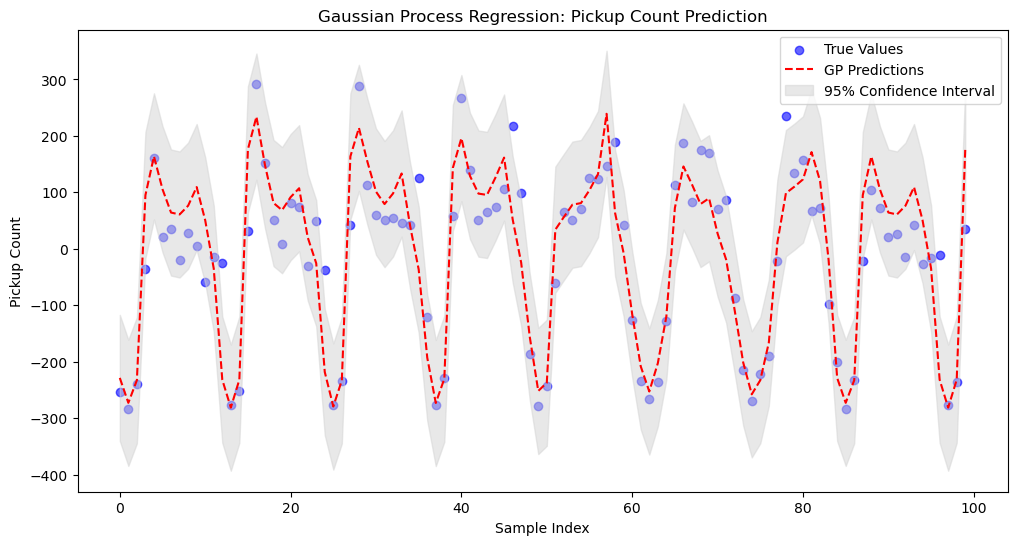

In [ ]:
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"R^2 Score: {r2:.3f}")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test[:100])), y_test[:100], label="True Values", color="blue", alpha=0.6)
plt.plot(range(len(y_pred[:100])), y_pred[:100], label="GP Predictions", color="red", linestyle="dashed")
plt.fill_between(
    range(len(y_pred[:100])),
    y_pred[:100] - 1.96 * sigma[:100],
    y_pred[:100] + 1.96 * sigma[:100],
    color="lightgrey",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel("Pickup Count")
plt.title("Gaussian Process Regression: Pickup Count Prediction")
plt.legend()
plt.show()

In [ ]:
sigma.mean() * 1.96

np.float64(111.73616895506272)

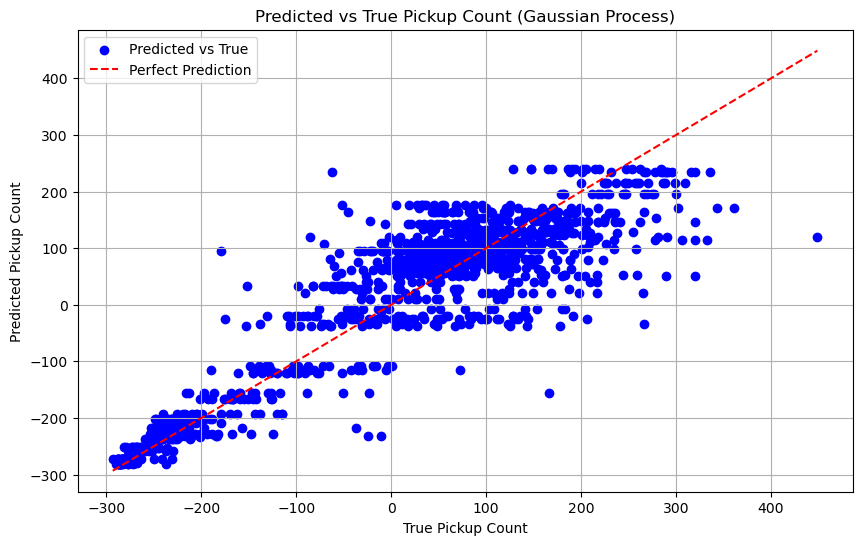

In [ ]:
# Prediction vs True Values plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs True')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('True Pickup Count')
plt.ylabel('Predicted Pickup Count')
plt.title('Predicted vs True Pickup Count (Gaussian Process)')
plt.legend()
plt.grid(True)
plt.show()

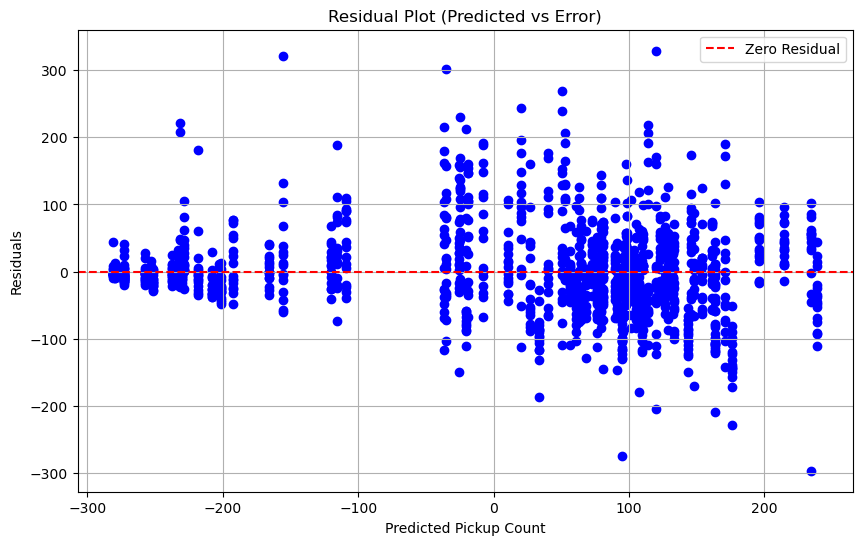

In [ ]:
# Compute residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Predicted Pickup Count')
plt.ylabel('Residuals')
plt.title('Residual Plot (Predicted vs Error)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

# R²
r2 = r2_score(y_test, y_pred)
print("R²:", r2)


RMSE: 66.0758183811038
R²: 0.8342269407978458


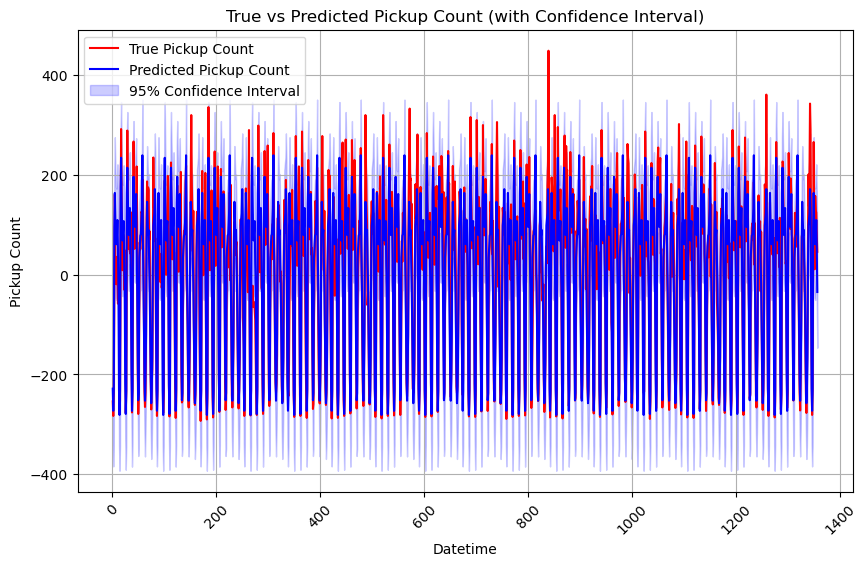

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test['time_index'], y_test, label='True Pickup Count', color='red')
plt.plot(test['time_index'], y_pred, label='Predicted Pickup Count', color='blue')
plt.fill_between(test['time_index'], y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, color='blue', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Datetime')
plt.ylabel('Pickup Count')
plt.title('True vs Predicted Pickup Count (with Confidence Interval)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()